In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
# global imports
import os
import shutil
# torch imports
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [26]:
# global constant definitions
EPOCHS = 5
LR = 1e-4

In [33]:
BASE_LOG_DIR = os.path.join(os.getcwd(), "tboard_logs")

os.makedirs(BASE_LOG_DIR, exist_ok=True)

## Task 1

 - Implement the (adapted) TriNet Siamese model and SimCLR:
    - ResNet convolutional backbone (until AvgPool) 
    - Fully connected frontend to obtain desired embedding
    - Normalization layer
 - Use *Labeled Faces in the Wild* (LFW) dataset (https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)
    - Over 13000 images
    - Train and test set
 - Train and Evaluate TriNet and SimCLR models
    - Try to find adequate temperature and margin values 
    - How do the models compare?
 - Evaluate and compare the model performance (need not be thorough)
 - Visualize embeddings (not necessary for all classes, e.g. pick the 10 classes with the most images)

### Dataset

In [6]:
# RUN once to save locally
# import kagglehub

# path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

# SAVE_PATH = "./data"
# os.makedirs(SAVE_PATH, exist_ok=True)
# shutil.move(path, SAVE_PATH)

/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112M/112M [00:03<00:00, 34.4MB/s]

Extracting model files...


'./data/4'

In [16]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

IMG_SIZE = 64
DATASET_PATH = "./data/4/lfw-deepfunneled/lfw-deepfunneled"

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

lfw_dataset = ImageFolder(DATASET_PATH, transform=transform)

In [17]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

TEST_SPLIT = .2

indices = list(range(len(lfw_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=TEST_SPLIT, random_state=42)

train_img_dataset = Subset(lfw_dataset, train_idx)
test_img_dataset = Subset(lfw_dataset, test_idx)

In [18]:
from TripletDataset import TripletDataset

test_dataset = TripletDataset(test_img_dataset)
train_dataset = TripletDataset(train_img_dataset)

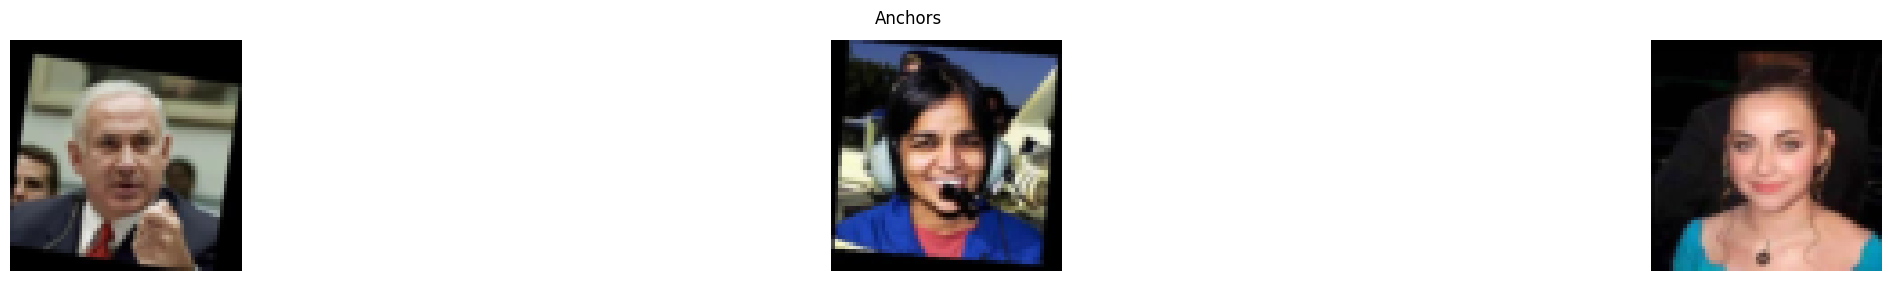

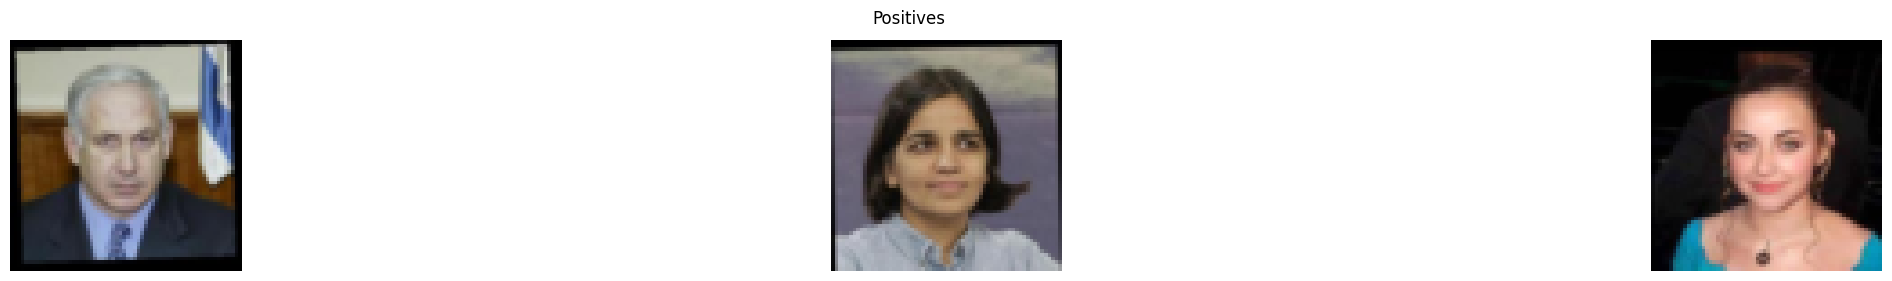

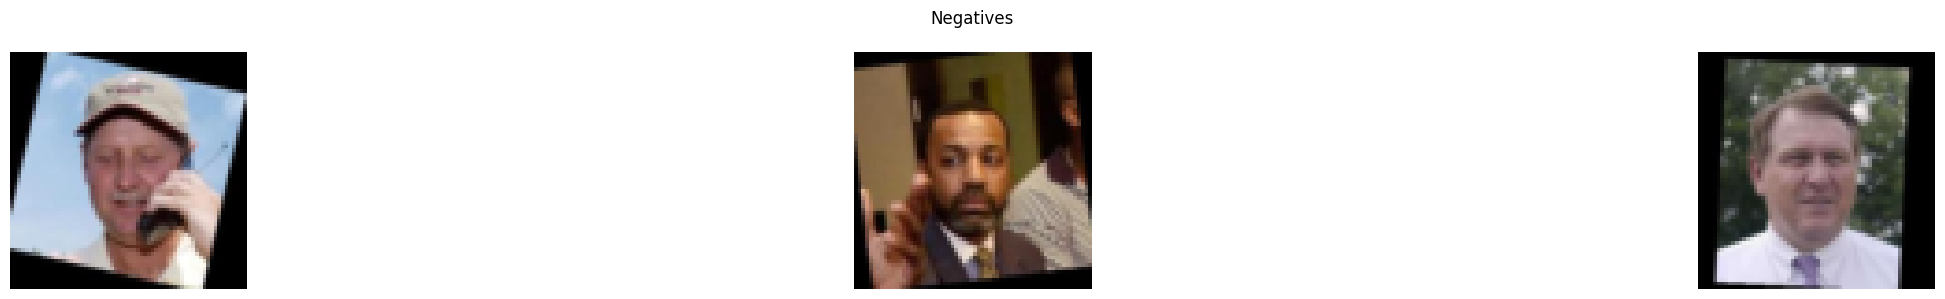

In [19]:
SUBPLOT_COUNT = 3

fig_anchors, anchors = plt.subplots(1, SUBPLOT_COUNT, figsize=(30, 3))
fig_pos, positives = plt.subplots(1, SUBPLOT_COUNT, figsize=(30, 3))
fig_neg, negatives = plt.subplots(1, SUBPLOT_COUNT, figsize=(30, 3))

for i in range(SUBPLOT_COUNT):
    (anchor, positive, negative), _ = train_dataset[i]
    
    # [C, H, W] -> [H, W, C] for matplotlib
    anchors[i].imshow(anchor.permute(1, 2, 0).numpy())
    anchors[i].axis("off")
    
    positives[i].imshow(positive.permute(1, 2, 0).numpy())
    positives[i].axis("off")
    
    negatives[i].imshow(negative.permute(1, 2, 0).numpy())
    negatives[i].axis("off")

fig_anchors.suptitle("Anchors")
fig_pos.suptitle("Positives")
fig_neg.suptitle("Negatives")

plt.tight_layout()
plt.show()

In [20]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=False) 

### TriNet Siamese model

In [28]:
from train import Trainer

In [31]:
from models.SiameseModel import SiameseModel
from TripletLoss import TripletLoss

model = SiameseModel()
criterion = TripletLoss(margin=0.2)
model

/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/user/imashevv1/CudaLabSS25/venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SiameseModel(
  (backbone): ResNetBackbone(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): Ba

In [35]:
from datetime import datetime

timestamp = datetime.now().strftime("%H-%M_%d-%m-%Y")
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs", "Siamese", timestamp)

os.makedirs(TBOARD_LOGS, exist_ok=True)
writer = SummaryWriter(TBOARD_LOGS)

In [19]:
trainer = Trainer(model=model, criterion=criterion, train_loader=train_loader, valid_loader=test_loader, n_iters=1000)

In [20]:
trainer.fit()

Valid loss @ iteration 0: Loss=0.062168404105163756


Valid loss @ iteration 250: Loss=0.024987333010704743


Valid loss @ iteration 500: Loss=0.01675310630595223


Valid loss @ iteration 750: Loss=0.01640814378680218


Train Iter 999: Loss=0.00646):   0%|          | 0/1000 [01:26<?, ?it/s]


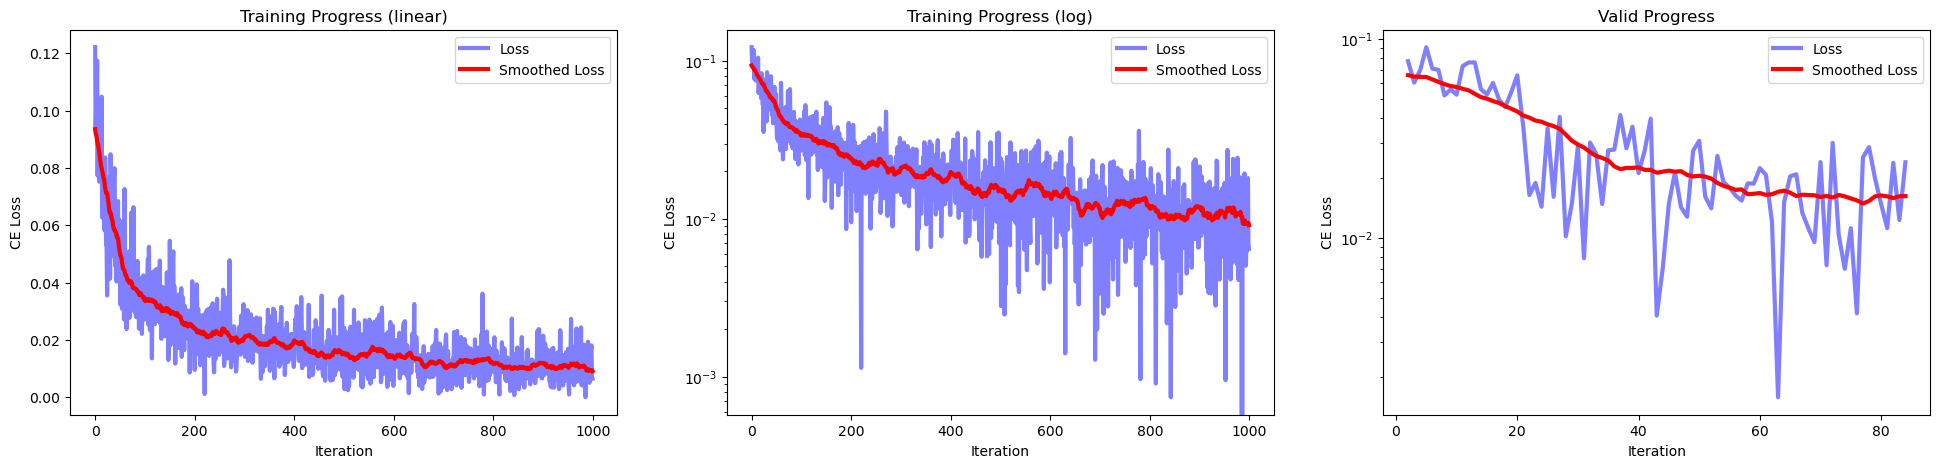

In [25]:
from utils.visualize_progress import visualize_progress

visualize_progress(trainer.train_loss, trainer.valid_loss, start=1)
plt.show()

### SimCLR model

In [13]:
from SimCLRDataset import SimCLRDataset

BATCH_SIZE = 128
simclr_db = SimCLRDataset(lfw_dataset)
data_loader = torch.utils.data.DataLoader(
        simclr_db,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4
    )

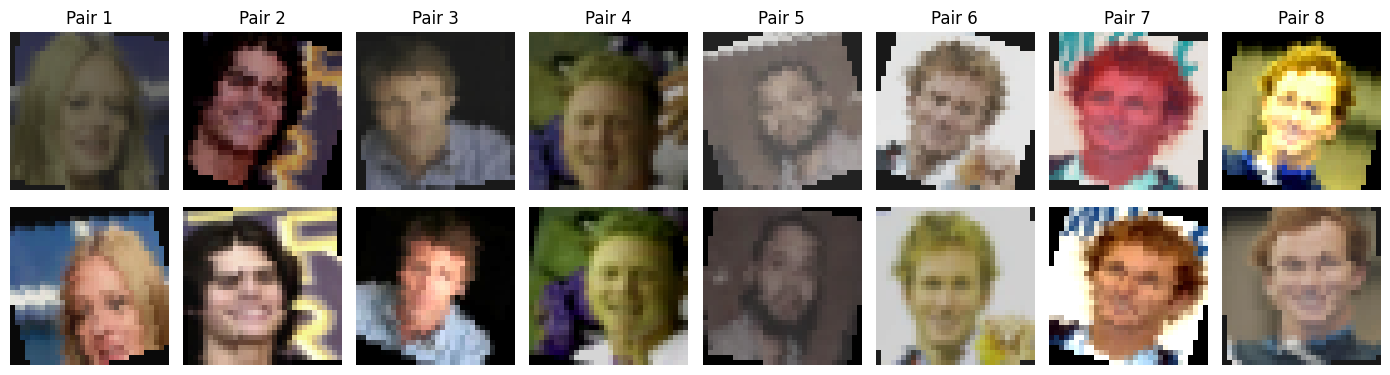

In [15]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('default')

fig, ax = plt.subplots(2, 8)
fig.set_size_inches(14, 4)
for i in range(8):
    view1, view2 = simclr_db[i]
    ax[0, i].imshow(view1.permute(1, 2, 0))
    ax[1, i].imshow(view2.permute(1, 2, 0))
    ax[0, i].axis("off")
    ax[1, i].axis("off")
    ax[0, i].set_title(f"Pair {i+1}")

plt.tight_layout()
plt.show()

In [39]:
import torch.nn.functional as F

def nt_xent_loss(z_i, z_j, temperature=0.1):
    """
    Normalized Temperature-scaled Cross Entropy Loss
    """
    B, dim = z_i.shape
    
    # Concatenate positive pairs
    z = torch.cat([z_i, z_j], dim=0)  # Shape: (2 * B, dim)
    # Compute similarity matrix
    sim_matrix = torch.mm(z, z.T) / temperature  # Shape: (2 * B, 2 * B)
    
    # Mask to remove self-similarity (diagonal)
    mask = torch.eye(2 * B, dtype=torch.bool).to(z.device)
    sim_matrix_final = sim_matrix.masked_fill(mask, float('-inf'))
    sim_matrix_vis = sim_matrix

    positives_labels = torch.cat([torch.arange(B, 2*B), torch.arange(0, B)]).to(z.device)

    # Compute cross entropy loss
    loss = F.cross_entropy(sim_matrix_final, positives_labels, reduction="mean")
    return loss, sim_matrix_vis

In [ ]:
from tqdm import tqdm

from models.SimCLR import SimCLR

# Hyperparameters
NUM_EPOCHS = 10
LR = 1e-3
TEMP = 0.5

simclr_dataset = SimCLRDataset(lfw_dataset)

train_loader = torch.utils.data.DataLoader(
    simclr_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# model and optimizer
model = SimCLR().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# Training Loop
print("Starting SimCLR training...")
for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0

    for batch_idx, (x_i, x_j) in enumerate(tqdm(train_loader)):
        x_i, x_j = x_i.to(device), x_j.to(device)

        # Forward pass
        z_i = model(x_i)
        z_j = model(x_j)

        # Loss
        loss, _ = nt_xent_loss(z_i, z_j, TEMP)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Batch {batch_idx}, Loss: {loss.item():.4f}')

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} complete. Average Loss: {avg_loss:.4f}")


Starting SimCLR training...


  4%|▍         | 4/104 [00:00<00:10,  9.87it/s]

Epoch 1/10, Batch 0, Loss: 5.5019


 98%|█████████▊| 102/104 [00:07<00:00, 15.58it/s]

Epoch 1/10, Batch 100, Loss: 4.2510


100%|██████████| 104/104 [00:07<00:00, 14.05it/s]


Epoch 1 complete. Average Loss: 4.4950


  1%|          | 1/104 [00:00<00:36,  2.81it/s]

Epoch 2/10, Batch 0, Loss: 4.3436


100%|██████████| 104/104 [00:07<00:00, 14.26it/s]


Epoch 2/10, Batch 100, Loss: 4.3386
Epoch 2 complete. Average Loss: 4.2455


  1%|          | 1/104 [00:00<00:36,  2.80it/s]

Epoch 3/10, Batch 0, Loss: 4.1843


100%|██████████| 104/104 [00:07<00:00, 14.35it/s]


Epoch 3/10, Batch 100, Loss: 4.2063
Epoch 3 complete. Average Loss: 4.1833


  1%|          | 1/104 [00:00<00:36,  2.83it/s]

Epoch 4/10, Batch 0, Loss: 4.1650


100%|██████████| 104/104 [00:07<00:00, 14.26it/s]


Epoch 4/10, Batch 100, Loss: 4.1267
Epoch 4 complete. Average Loss: 4.1487


  2%|▏         | 2/104 [00:00<00:30,  3.36it/s]

Epoch 5/10, Batch 0, Loss: 4.1702


100%|██████████| 104/104 [00:08<00:00, 12.44it/s]


Epoch 5/10, Batch 100, Loss: 4.0625
Epoch 5 complete. Average Loss: 4.1204


  1%|          | 1/104 [00:00<00:37,  2.75it/s]

Epoch 6/10, Batch 0, Loss: 4.1572


100%|██████████| 104/104 [00:07<00:00, 14.36it/s]


Epoch 6/10, Batch 100, Loss: 4.0887
Epoch 6 complete. Average Loss: 4.0908


  1%|          | 1/104 [00:00<00:37,  2.73it/s]

Epoch 7/10, Batch 0, Loss: 4.0116


100%|██████████| 104/104 [00:07<00:00, 14.48it/s]


Epoch 7/10, Batch 100, Loss: 4.0556
Epoch 7 complete. Average Loss: 4.0692


  1%|          | 1/104 [00:00<00:36,  2.83it/s]

Epoch 8/10, Batch 0, Loss: 4.0755


100%|██████████| 104/104 [00:07<00:00, 14.25it/s]


Epoch 8/10, Batch 100, Loss: 4.0267
Epoch 8 complete. Average Loss: 4.0491


  1%|          | 1/104 [00:00<00:37,  2.78it/s]

Epoch 9/10, Batch 0, Loss: 4.0979


100%|██████████| 104/104 [00:07<00:00, 14.40it/s]


Epoch 9/10, Batch 100, Loss: 4.0698
Epoch 9 complete. Average Loss: 4.0345


  1%|          | 1/104 [00:00<00:36,  2.81it/s]

Epoch 10/10, Batch 0, Loss: 4.0320


100%|██████████| 104/104 [00:07<00:00, 14.31it/s]

Epoch 10/10, Batch 100, Loss: 3.9879
Epoch 10 complete. Average Loss: 4.0204
